# GHZ state implementation- Optimized and Naive Approaches 
In this notebook, we aim at improving the implementation of the iniital state preparation of the GHZ state, given a specific arbitrary architecture geometry of the quantum hardware. In particular, we focused on the available machines provided by IBM Quantum on their platform.
Our code is capable of running for any general architecture, taken from the backend, of any number of qubits N. 
Results: _report_

## Method
The method we used consists of using computational methods on graph to find the most suitable initialisation algorithm for the GHZ state, given a specific architecture geometry. In particular, given a particular backend (either simulated or real), we translate its geometry into a graph with weights on the edges that are a function of the CNOT error reported. Then, we identify the optimal node from which to start the state initialization algorithm as well as the hierarchial order in which the qubits are affected by CNOTs. Finally, we provide an analysis of the performance of our optimized solution by doing full state tomography of the resulting state prepared using a real noise model of a real backend, and compare it against the naive way of creating the GHZ state. In this analysis, we benchmark our results against the performances of the standard initialisation algorithm implemented automatically by qiskit. 

The standard implementation of preparing GHZ by Qiskit- scales exponentially and is explained further down.

### Qualitative Analysis and Benchmarking of our algorithm to make GHZ states:
Here we analyse the performances of the standard state initialization algorithm provided by Qiskit. Let's start from the following example.

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, execute, Aer, transpile
from qiskit.extensions import Initialize

# Define the desired statevector
desired_statevector = [1/np.sqrt(2), 0, 0, 0, 0, 0, 0, 1/np.sqrt(2)]

# Create a quantum circuit
num_qubits = int(len(desired_statevector).bit_length() - 1)
circuit = QuantumCircuit(num_qubits)

# Initialize the state to the desired statevector
initialize_gate = Initialize(desired_statevector)
circuit.append(initialize_gate, range(num_qubits))

circuit.draw('mpl')

This short circuit initialises our 3-qubit quantum circuit into the 3-dimensional GHZ state, i.e.

$$|\psi\rangle = \frac{|000\rangle + |111\rangle}{\sqrt{2}}.$$

However, the complexity of such a circuit relies on its implementation. At its core, the synthesis algorithm is the one presented in "Synthesis of Quantum Logic Circuits" by Shende, Bullock, Markov (https://arxiv.org/abs/quant-ph/0406176v5). The underlying principle is the following. A theorem proven thereby shows how to get a desired qubit (either $|0\rangle$ or $|1\rangle$) on the least significant bit, starting from an arbitrary state. Applying the theorem recursively can reduce a given n-qubit quantum state $|\psi\rangle$ to a scalar multiple of adesired bitstring state $|b\rangle$. The resulting circuit $\mathcal{C}$ uses 

$$2^{n+1}-2n$$ 

CNOT gates. To go from $|b\rangle$ to $|\psi\rangle$, they apply the gates in $\mathcal{C}$ but in reversed order and inverted (i.e. $\mathcal{C}^\dagger$). Even though this approach remains more general than our, we aimed at developing particularly efficient algorithms specifically built for GHZ state initialization and for given machine architectures. The decomposition in smaller gates of the initialisation to GHZ state in 3 dimensions can be found below.

In [ ]:
# Transpile the circuit in terms of Hadamard and CNOT gates
decomposed_circuit = transpile(circuit, basis_gates=['h', 'cx', 'ry', 'rx'])
decomposed_circuit.draw('mpl')

In [ ]:
print("Depth of the circuit : " , decomposed_circuit.depth())

The expected depth of the circuit is $2^{3+1}-6 = 10$ and is lower than the computed one (11). Our implementation already changes the scaling from exponential to linear (in the worst case). Nevertheless, the additional optimisation accounting for the particular CNOT error on qubits' connections improves the factor of the linear scaling greatly. We can further improve the depth of the circuit, but this would highly depend on the hardware of the architecture of the IBM quantum computer. 


# Process of reading out the Graph from the backend: 
In the following ceel, we present the code using which we have read out the graph in order to convert the hardware architecture of IBM quantum computing systems or 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit.providers.fake_provider import FakeWashington

# Get a backend (we choose the FakeWashington backend as in the optimized part above)
backend = FakeWashington()

# Get the configuration of the backend and extract the qubit coupling map
config = backend.configuration()
coupling_map = config.coupling_map
properties = backend.properties()

# Create a graph using NetworkX
G = nx.Graph()

# Add the qubits as nodes
G.add_nodes_from(range(config.n_qubits))

# Add edges with gate error rates as weights
for qubit1, qubit2 in coupling_map:
    gate_error = properties.gate_error('cx', [qubit1, qubit2])
    G.add_edge(qubit1, qubit2, weight=gate_error)

# Remove edges to make the simplest tree
for edge in G.edges:
    G.remove_edge(edge[0],edge[1])
    if nx.is_connected(G) == False:
        G.add_edge(edge[0],edge[1],weight=gate_error)
    
# Draw the graph with edge labels
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
for key in labels:
    labels[key] = round(labels[key], 3)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

Once the graph is obtained, we show that even when the short path tree graph of connections between qubits is chosen, the performances are still not as good as the optimised ones above. This is made evident by the following statistics.
The entries taken by our code are in the form of the graph from the backend, and so our algorithm works for any generalised graph given of any number of qubits N. 


We first explain our algorithm and then explain the standard way of preparing the GHZ state later on. 

# Part A: Optimized GHZ state initialization
Motivation for us to write a new algorithm: 

In the following, we motivate how we chose the method for finding a GHZ
creation circuit which takes into account hardware constraints, error rates and
has low depth. We begin by describing the most naive way of creating a GHZ
state that ignores hardware constraints, and then outline the ideas that lead us
to our method, supported by concrete examples for different hardware connectivities

## Method 1: Naive GHZ state creation without regard to hardware:
The most naive algorithm to prepare a N-qubit GHZ state it to apply a Hadamard gate to qubit 0 and then sequentially apply CNOT(i,i+1) for i in range(i,N). This circuit has depth N if the backend has all-to-all connectivity, but if it has limited connectivity, we might need to use SWAP gates to be able to perform CNOT gates between qubits that are not nearest neighbors. Since each SWAP gate consists of 3 CNOT gates, this leads to a significant overhead. 

To illustrate this, consider the following example: 

Consider the graph shown in the figure below.
The "theoretical depth" if we had all-to-all connectivity for N=5 qubits is 5. Now, if we take into account the connectivity of the given graph, to execute the naive GHZ creation, we would have to use 2xSWAP(1,2) and 2xSWAP(1,4) to perform CNOT gates between CNOT(2,3) and CNOT(3,4) respectively. This leads to a circuit depth of 17. 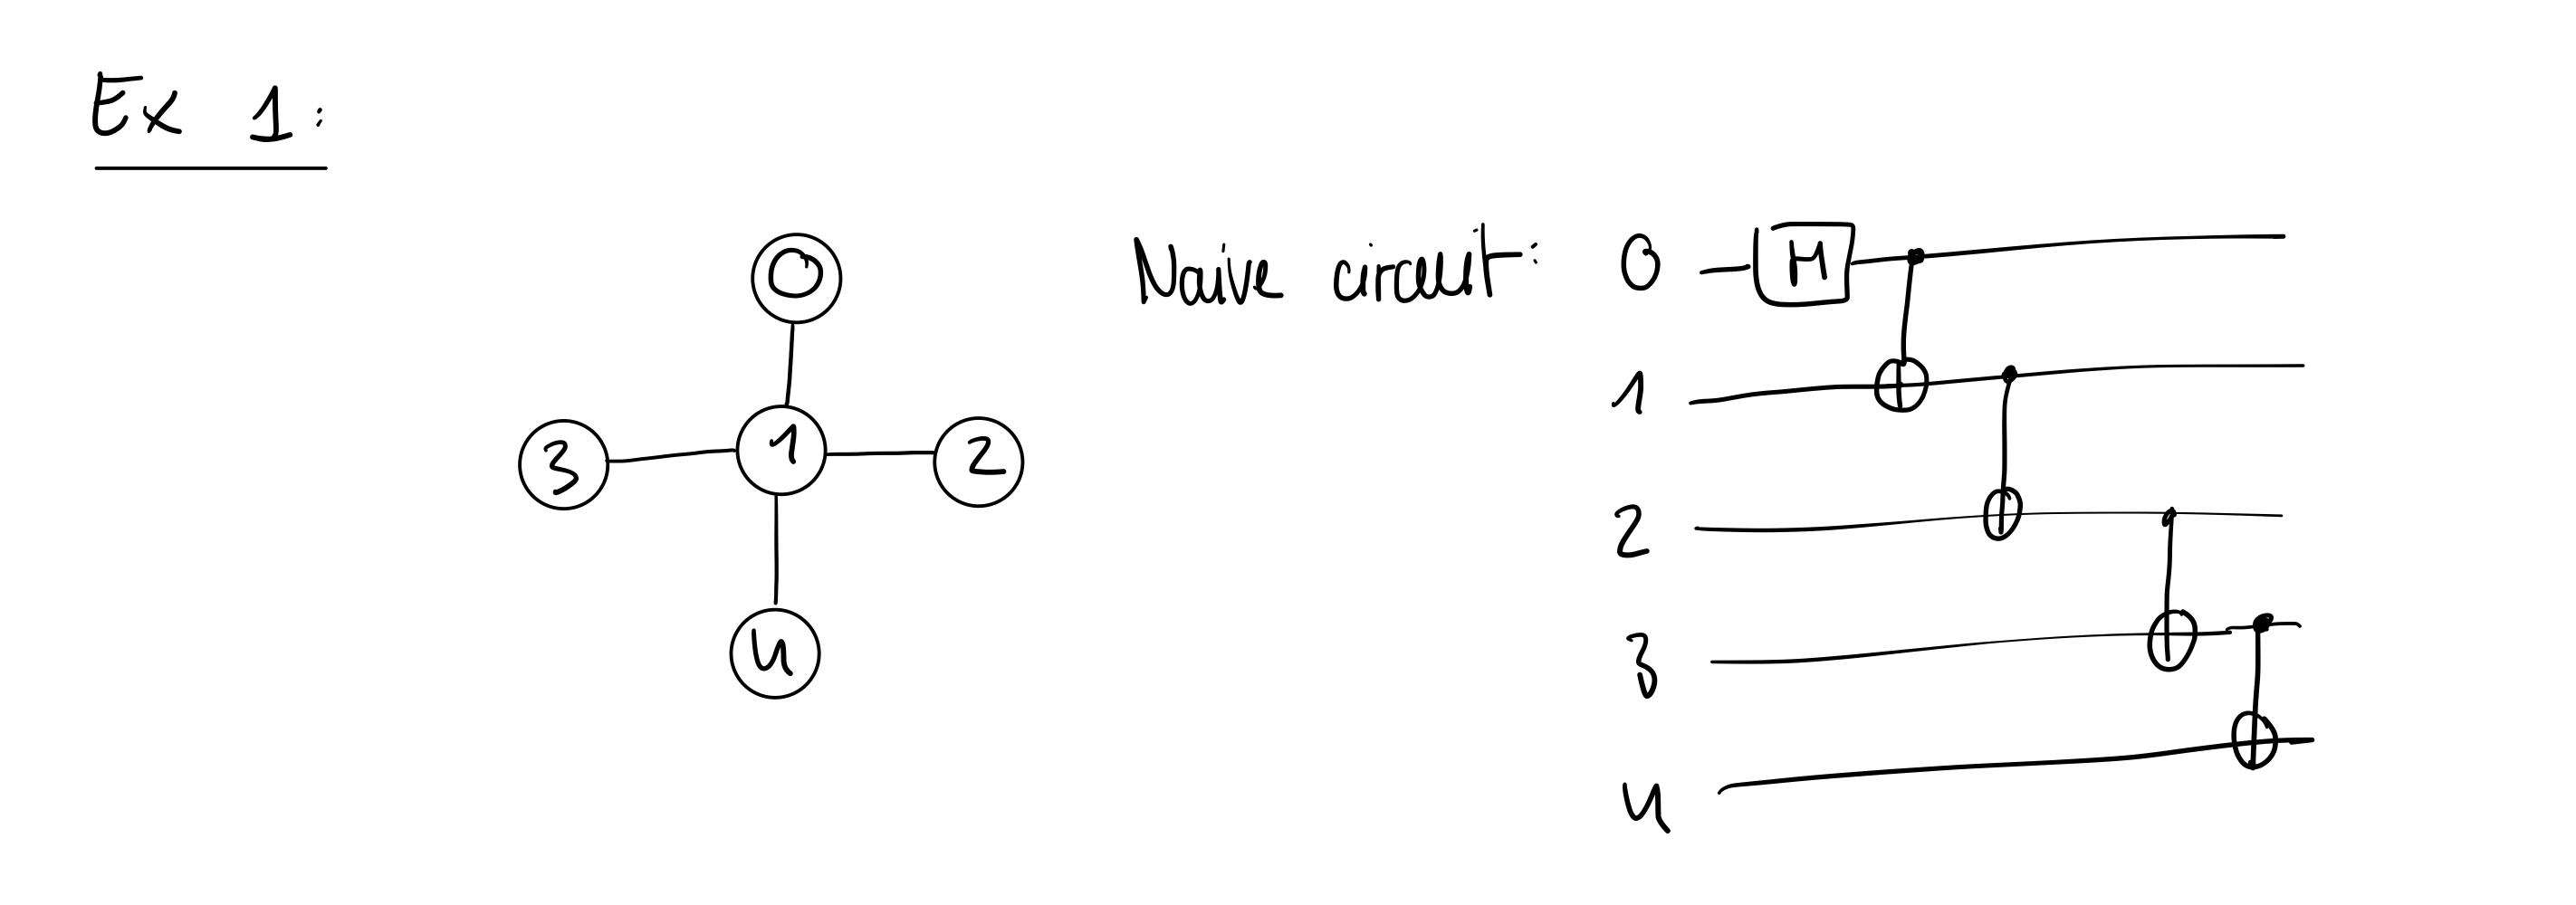

## Step 2: Avoid SWAPs by using a spanning tree for state creation}

We can avoid having to use SWAP gates for the GHZ state creation if we change the way in which we apply the CNOT gates for the state creation. To create a GHZ state, we just need to pick a starting qubit $s$ and apply CNOT gates in such a way that the following conditions hold: only use a qubit as control if it was already targeted (or is $s$), only target each non-starting qubit once (and the starting qubit is never used as target). \\

If we wanted to use a directed graph T to describe the way in which the CNOT gates are applied, which has an edge (i,j) iff CNOT(i,j) is used in the state creation process, this results in a graph T which is a directed spanning tree of G (where G = (V,E) is the graph s.t. V = qubits, E = connectivity map of hardware) such that all vertices (qubits) can be reached from the starting vertex (qubit). 

For an example, see the figure below. Note that this circuit creates a GHZ state, takes into consideration the hardware constraints and does not use SWAPs, and we get a state creation circuit of depth 5, which is much better than the depth 17 we got from the naive approach before that. In general, since a spanning tree has N-1 edges, we need to apply N-1 CNOTs for this state creation. This circuit for state creation in the worst case has depth (maximum degree of T - 1)*(N-1) + 1. The prefactor takes into account the fact that we cannot parallelize CNOTs that have the same target qubit, the (N-1) factor is the number of CNOTs that we have to apply, and the 1 additive term is due to the Hadamard gate that we have to apply to the starting qubit.\\

Note that the max_degree(spanning_tree) factor does not affect the asymptotics too badly for superconducting circuits, since the maximum, since the maximum degree of the connectivity map is usually a low integer and does not scale with the number of qubits. In IBMs currrent hardware, the larger platforms (127,433 qubits) have a maximum degree of 3.

Example 2: start with 0 and do spreading thing: depth 5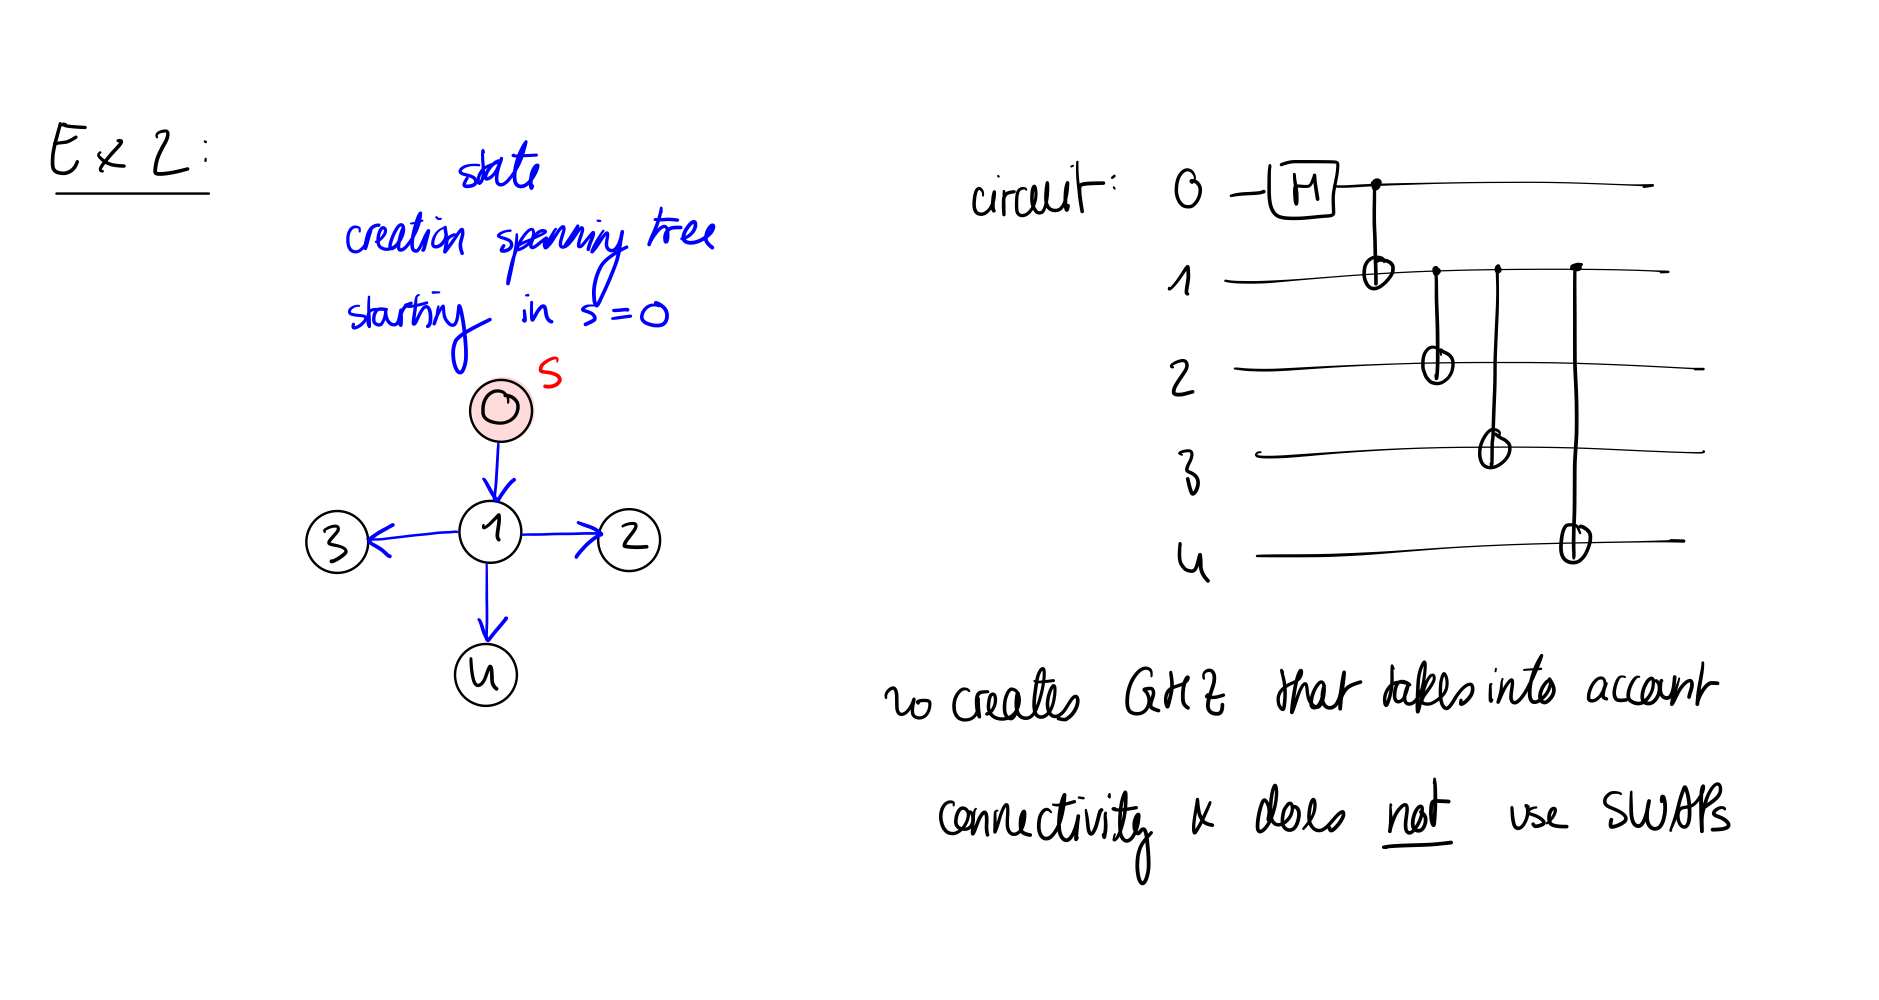

## Method 3: Find optimal state creation spanning tree given a specific starting qubit

We would like, however, to optimize this "state creation spanning tree" T. The depth is (if we for now ignore the fact that we cannot parallelize CNOTs that have the same target qubit, but we will worry about that later) dictated by the length of the longest (s,v) path on the "state creation spanning tree" T. We can thus improve on our depth by finding the shortest path tree with start vertex $s$. An algorithm for doing so is described in [https://en.wikipedia.org/wiki/Shortest-path_tree] and uses Dijkstra's algorithm as subroutine. This algorithm has complexity polynomial in the number of qubits, and is thus efficient. Note that if we ignore errors, we would just set the edge weights to 1, but by making the edge weights dependent on the CNOT error rate, we can also include a preference for edges with lower error - more to that later.

To see why this can improve the depth, consider the example in the figure shown below.

Example 3: for a more complicated graph, instead of 0, choose min shortest path lenght vertex as starting point, e.g. if you have linear architecture (and say we do not take into account errors, so all edges have weight 1) better to take midpoint than vertex at edge, then depth is like N/2 + 1.! 
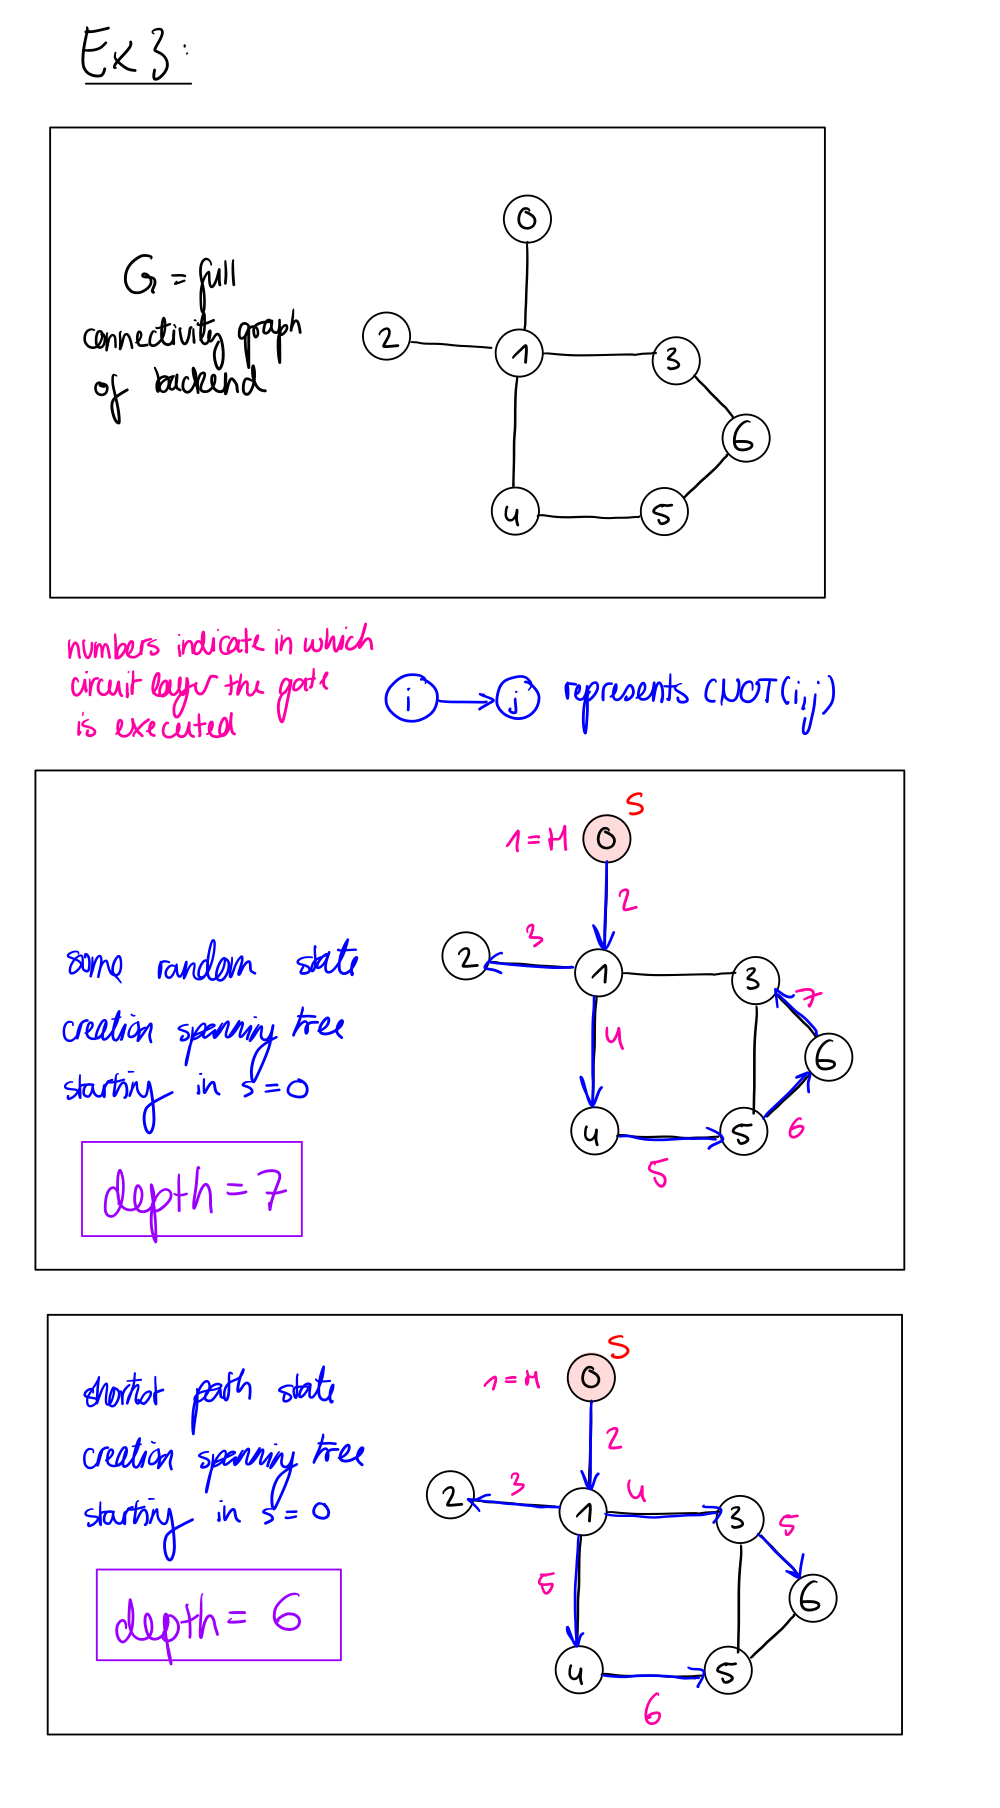

## Method 4: Improve further by finding best starting qubit

We can further optimize by choosing the starting point s which has the minimum longest s-v-path on its shortest path tree. We do this by just running the shortest path tree algorithm for all possible qubits as starting point, i.e. running the shortest path tree algorithm from before N times, which still leads to a classical runtime polynomial in the number of qubits and is thus efficient. 
This can be efficiently done classically polynomially in the number of qubits.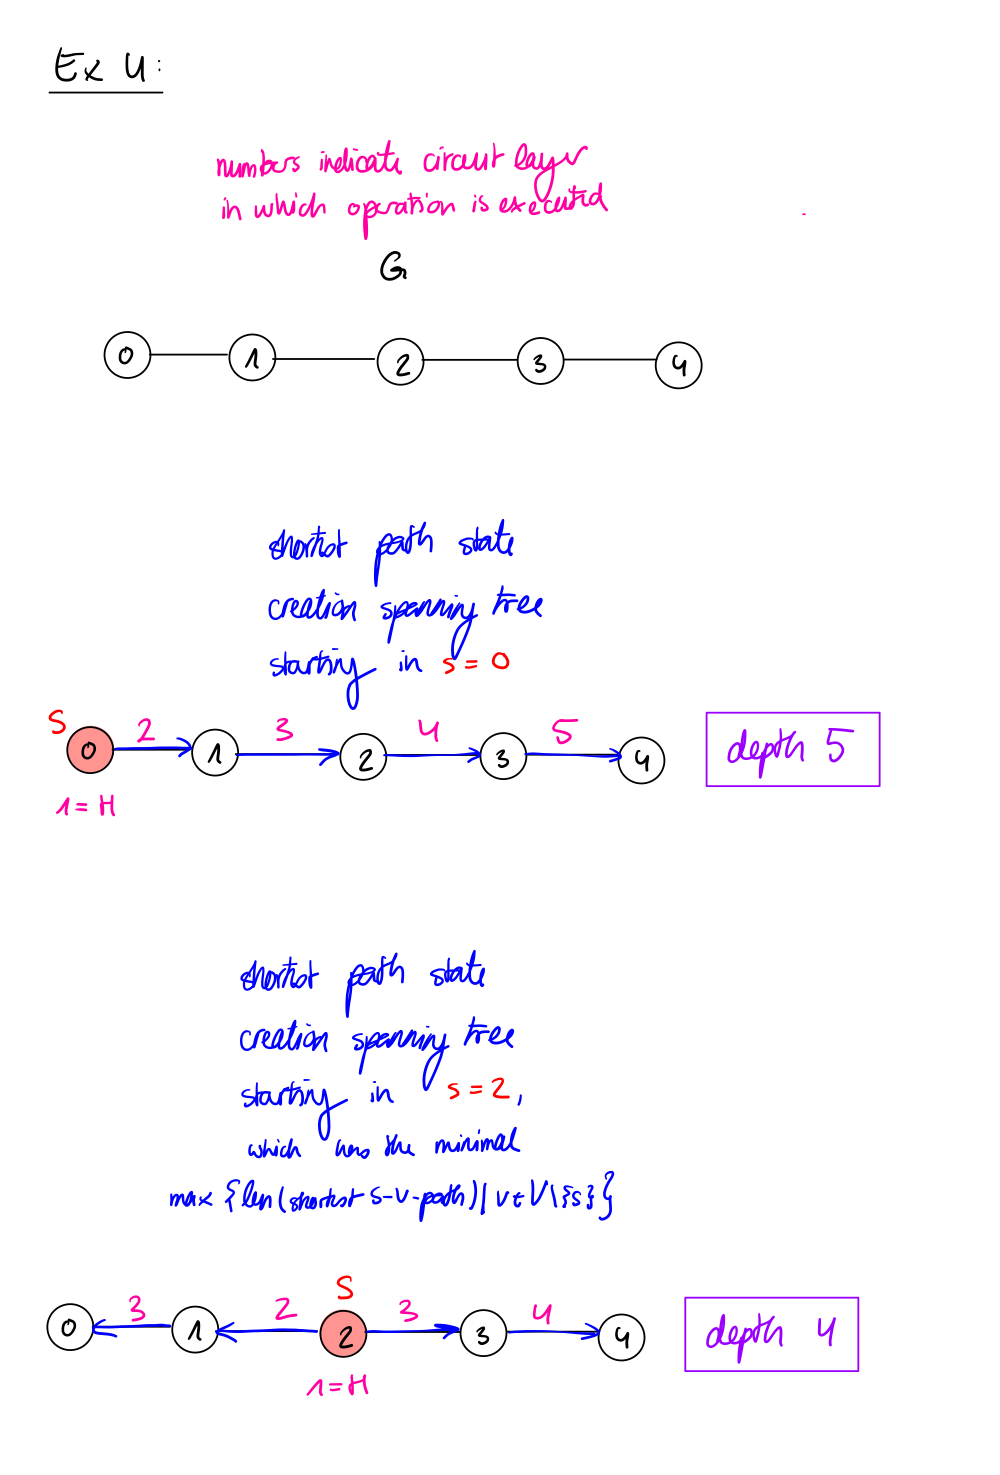

## Method 5: Take into account fact that we cannot parallelize CNOTs that have the same control qubit:

As mentioned before, the depth of the circuit is not just dictated by the maximum-lenght s-v-path in the shortest path tree - we also need to take into account that we for a given control qubit, we cannot apply a CNOT between this qubit and its neighbors on the spanning tree graph at once. Thus, say that for the maximum length path $p$ in the state creation graph, the algorithm always prefers to apply other CNOTs before "continuing down" path p, then the depth of this circuit will worst-case approach the worst-case bound (max_degree(spanning tree) - 1)*length of the longest path + 1, see in Ordering 1 in the example below.

We can reduce this, however, if at each controlling qubits, we decide to apply the CNOT preferentially first to the neighbors that have much more qubits coming after them in the circuit, i.e. the neighbor which has the longest directed path attached to it in the state creation graph, as is done in Ordering 2 in the example below. This further optimizes our state creation depth. By how much this can improve the depth compared to the previous method depends on the graph connectivity - if there are many maximal length paths, the prioritization scheme might not lead to an improvement.

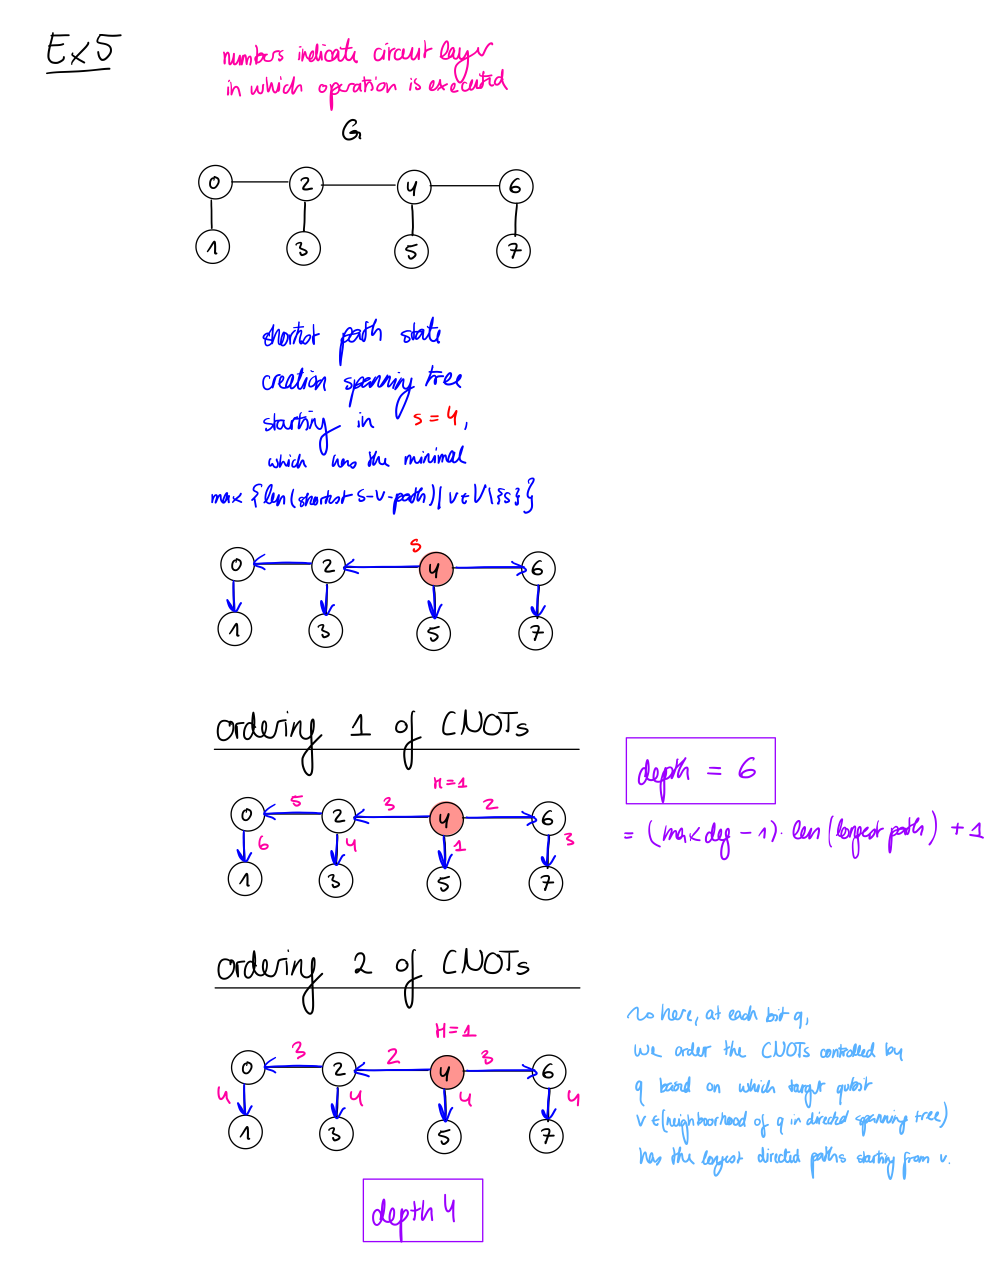

### Take into account variation in CNOT-gate quality in real hardware
Now back to taking into account the CNOT error rate: we propose to do this by taking the weights of the edges in the connectivity graph G to be to be $w(i,j) = 1/(1-x_{i,j})**c$ for $x_{i,j}$ = CNOT error rate between the qubits (i,j), and c some fixed constant c (can also just be 1) to optimize. We choose this function because for $x_{i,j} = 0$, we have $w(i,j) = 1$, so the weight of a perfect CNOT gate is 1 (and this is the minimal weight), and if $x_{i,j} = 1$, i.e. the CNOT gate is basically unusable, we get $w(i,j) = \inf$, so the shortest path algorithm will never use this edge (if we discard all qubits/islands of qubits that are only connected to the rest of the qubits by CNOTS with error rate 1, i.e. if we try to create a GHZ state for the largest connected component of the connectivity graph G where we discard all edges that have CNOT error rate 1).


# Optimized Algorithm(converted into the graph problem)

In [6]:
# Graph functions: 
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from qiskit import IBMQ, QuantumCircuit
import qiskit.providers.fake_provider as fp


def get_graph_from_backend(backend, fake=True, weight_function=lambda x: 1/(1-x)):

    if not fake:
        assert type(backend) == str, "backend must be a string"
        IBMQ.load_account()        
        provider = IBMQ.get_provider(hub='ibm-q')
        backend = provider.get_backend(backend)  # something like 'ibmq_lima'      
        
    if fake:
        assert type(backend) == backend.__class__, "backend must be a backend object"

    try:
        config = backend.configuration()
        properties = backend.properties()
        coupling_map = config.coupling_map
    except:
        print("WARNING: most probable error is that you are using a V2 fake backend, you should use a V1 fake backend")

    G = nx.Graph()
    G.add_nodes_from(range(config.n_qubits))

    num_weight_one_edges = 0
    for qubit1, qubit2 in coupling_map:
        gate_error = properties.gate_error('cx', [qubit1, qubit2])
        #print("gate error:\n", gate_error)

        # Skip adding edges with gate error of 1        
        if gate_error != 1:
            f_gate_error = weight_function(gate_error)
            G.add_edge(qubit1, qubit2, weight=f_gate_error)
        if gate_error == 1:
            num_weight_one_edges += 1

    # Keep only the largest connected component
    connected_components = list(nx.connected_components(G))

    num_connected_components = len(connected_components)

    # Calculate number of nodes in each component here before modifying the graph
    number_of_nodes_in_components = [len(component) for component in connected_components]

    
    if num_connected_components > 1:
        # sort by length, from largest to smallest
        connected_components.sort(key=len, reverse=True)
        largest_component = connected_components[0]

        # Keep only the largest component
        G = G.subgraph(largest_component).copy()
    
    print("REPORT: get_graph_from_backend:")
    print("Number of qubits: ", config.n_qubits)
    print("Number of weight 1 edges: ", num_weight_one_edges)
    print("Number of connected components: ", num_connected_components)
    print("with number of nodes in each component: ", number_of_nodes_in_components)
    print("Number of edges in new graph: ", G.number_of_edges())
    print("Number of nodes in new graph: ", G.number_of_nodes())

    return G




def get_tree_graph(G, root, weight_str='weight'):
    """
    returns a tree graph for a given root node
    """

    T = nx.Graph()
    T.add_nodes_from(G.nodes)

    shortest_paths = {node: nx.dijkstra_path(G, root, node, weight='weight') for node in G.nodes if node != root}

    for node, path in shortest_paths.items():
        if len(path) > 1:
            # Retrieve the weight from the original graph
            weight = G[path[-1]][path[-2]]['weight']
            # Add the edge to the tree
            T.add_edge(path[-1], path[-2], weight=weight)

    return T


def plot_graph(G):
    """
    Plots a given graph
    """
   # Draw the graph with edge labels
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    for key in labels:
        labels[key] = round(labels[key], 3)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()


def minimal_max_distance_root(G):
    """
    Returns the root node that minimizes the maximum distance
    between the root and any other node, and the number of nodes on that path
    """

    # Initialize variables to track the optimal root
    min_max_distance = np.inf
    optimal_root = None
    optimal_path = []

    # Loop over all nodes
    for node in G.nodes:
        # Compute the shortest path distances from this node to all others
        paths = nx.single_source_dijkstra_path(G, node, weight='weight')

        # Find the longest distance
        max_distance_path = max(paths.values(), key=len)
        max_distance = len(max_distance_path) - 1

        # Update the optimal root if this node is better
        if max_distance < min_max_distance:
            min_max_distance = max_distance
            optimal_root = node
            optimal_path_length = len(max_distance_path)

    return optimal_root, min_max_distance, optimal_path_length




def generate_directed_tree_from_root(shortest_path_tree, root):
    
    # Create a directed graph
    directed_tree = nx.DiGraph()

    # Add the nodes from the shortest path tree
    directed_tree.add_nodes_from(shortest_path_tree.nodes)

    # Create a list to keep track of processed nodes
    processed_nodes = [root]

    # Iterate until all nearest neighbors are processed
    while len(processed_nodes) < shortest_path_tree.number_of_nodes():
        # Iterate over the processed nodes
        for node in processed_nodes:
            # Iterate over the nearest neighbors of the current processed node
            for neighbor in shortest_path_tree.neighbors(node):
                # If the neighbor is not already processed, add a directed edge
                if neighbor not in processed_nodes:
                    directed_tree.add_edge(node, neighbor)
                    processed_nodes.append(neighbor)

    return directed_tree


def order_neighbors_by_distance(graph, node):
    """
    Order the neighbors of a node in a graph based on the distance to the furthest reachable node through each neighbor.

    Parameters:
    - graph: A networkx.Graph or networkx.DiGraph object.
    - node: The node whose neighbors will be ordered.

    Returns:
    - A list of tuples, each containing a neighbor and the distance to the furthest node reachable through that neighbor,
      ordered by the distance in descending order.
    """
    neighbors = list(graph.neighbors(node))
    distances = []

    for neighbor in neighbors:
        lengths = nx.single_source_dijkstra_path_length(graph, neighbor)
        max_length = max(lengths.values())
        distances.append((neighbor, max_length))

    # Sort the neighbors based on the distances in descending order
    distances.sort(key=lambda x: x[1], reverse=True)

    return distances

def generate_qc_from_tree(shortest_path_tree, optimal_root):
    # Create a mapping from node labels to indices
    node_to_index = {node: index for index, node in enumerate(shortest_path_tree.nodes)}

    # Create a quantum circuit
    qc = QuantumCircuit(len(shortest_path_tree.nodes), len(shortest_path_tree.nodes))

    # Apply Hadamard gate on the optimal root
    qc.h(node_to_index[optimal_root])

    # Create a list to keep track of processed nodes
    processed_nodes = [optimal_root]

    # Iterate until all nearest neighbors are processed
    while len(processed_nodes) < shortest_path_tree.number_of_nodes():
        # Iterate over the processed nodes
        for node in processed_nodes:
            # Iterate over the nearest neighbors of the current processed node
            neighbors_distances = order_neighbors_by_distance(shortest_path_tree, node)
            ordered_neighbors = [neighbor for neighbor, distance in neighbors_distances]
            for neighbor in ordered_neighbors:
                # If the neighbor is not already processed, apply CX gate
                if neighbor not in processed_nodes:
                    qc.cx(node_to_index[node], node_to_index[neighbor])
                    processed_nodes.append(neighbor)
    qc.measure(range(len(shortest_path_tree.nodes)), range(len(shortest_path_tree.nodes)))

    return qc


def generate_noisy_qc_from_tree(shortest_path_tree, optimal_root, multiplier):
    # Check that multiplier is odd
    if multiplier % 2 == 0:
        raise ValueError("Multiplier must be an odd number.")
    
    # Create a mapping from node labels to indices
    node_to_index = {node: index for index, node in enumerate(shortest_path_tree.nodes)}

    # Create a quantum circuit
    qc = QuantumCircuit(len(shortest_path_tree.nodes), len(shortest_path_tree.nodes))

    # Apply Hadamard gate on the optimal root
    qc.h(node_to_index[optimal_root])

    # Create a list to keep track of processed nodes
    processed_nodes = [optimal_root]

    # Iterate until all nearest neighbors are processed
    while len(processed_nodes) < shortest_path_tree.number_of_nodes():
        # Iterate over the processed nodes
        for node in processed_nodes:
            # Iterate over the nearest neighbors of the current processed node
            neighbors_distances = order_neighbors_by_distance(shortest_path_tree, node)
            ordered_neighbors = [neighbor for neighbor, distance in neighbors_distances]
            for neighbor in ordered_neighbors:
                # If the neighbor is not already processed, apply CX gate
                if neighbor not in processed_nodes:
                    # Repeat the CX gate multiplier times
                    for _ in range(multiplier):
                        qc.cx(node_to_index[node], node_to_index[neighbor])
                        #qc.barrier()
                    processed_nodes.append(neighbor)
    #qc.measure(range(len(shortest_path_tree.nodes)), range(len(shortest_path_tree.nodes)))

    return qc





########### OLD FUNCTIONS BELOW #####################





def get_graph_from_backend_old(backend, fake=True, weight_function=lambda x: x):

    if not fake:
        assert type(backend) == str, "backend must be a string"
        IBMQ.load_account()        
        provider = IBMQ.get_provider(hub='ibm-q')
        backend = provider.get_backend(backend)  # something like 'ibmq_lima'     
        
    if fake:
        assert type(backend) == backend.__class__, "backend must be a backend object"

    config = backend.configuration()
    properties = backend.properties()
    coupling_map = config.coupling_map

    G = nx.Graph()
    G.add_nodes_from(range(config.n_qubits))

    for qubit1, qubit2 in coupling_map:
        gate_error = properties.gate_error('cx', [qubit1, qubit2])
       # print("gate errors:\n", gate_error)
        try:
            gate_error=weight_function(gate_error)
        except:
            ZeroDivisionError
            gate_error = 1e30
        G.add_edge(qubit1, qubit2, weight=gate_error)

    return G

def generate_qc_from_tree_old(shortest_path_tree, optimal_root):
    
    # Create a quantum circuit
    qc = QuantumCircuit(len(shortest_path_tree.nodes), len(shortest_path_tree.nodes))

    # Apply Hadamard gate on the optimal root
    qc.h(optimal_root)

    # Create a list to keep track of processed nodes
    processed_nodes = [optimal_root]

    # Iterate until all nearest neighbors are processed
    while len(processed_nodes) < shortest_path_tree.number_of_nodes():
        # Iterate over the processed nodes
        for node in processed_nodes:
            # Iterate over the nearest neighbors of the current processed node
            for neighbor in shortest_path_tree.neighbors(node):
                # If the neighbor is not already processed, apply CX gate
                if neighbor not in processed_nodes:
                    qc.cx(node, neighbor)
                    processed_nodes.append(neighbor)

    return qc


def generate_qc_from_tree_old_new(shortest_path_tree, optimal_root):
    
    # Create a quantum circuit
    qc = QuantumCircuit(len(shortest_path_tree.nodes))

    # Apply Hadamard gate on the optimal root
    qc.h(optimal_root)

    # Create a list to keep track of processed nodes
    processed_nodes = [optimal_root]

    # Iterate until all nearest neighbors are processed
    while len(processed_nodes) < shortest_path_tree.number_of_nodes():
        # Iterate over the processed nodes
        for node in processed_nodes:
            # Iterate over the nearest neighbors of the current processed node
            neighbors_distances = order_neighbors_by_distance(shortest_path_tree, node)
            ordered_neighbors = [neighbor for neighbor, distance in neighbors_distances]
            for neighbor in ordered_neighbors:
                # If the neighbor is not already processed, apply CX gate
                if neighbor not in processed_nodes:
                    qc.cx(node, neighbor)
                    processed_nodes.append(neighbor)

    return qc


In [4]:
#code from Pieta

G = get_graph_from_backend(fp.FakeWashington(), fake=True, weight_function=lambda x : 1)
#plot_graph(G)
optimal_root, dist, vfh = minimal_max_distance_root(G)
#print("optimal_root:", optimal_root, "dist:",  dist)
T = get_tree_graph(G, optimal_root)
directed_T = generate_directed_tree_from_root(T, optimal_root)
#plot_graph(T)
qc = generate_noisy_qc_from_tree(directed_T, optimal_root=optimal_root, multiplier = 1)
#print(qc)
print("Depth", qc.depth())

KeyboardInterrupt: 

The above code produces the GHZ creation circuit for IBM Washington- which has 127 qubits. The depth is 18.
For a smaller backend architecture, we are also able to show the depth of the circuit. 
for eg. Cairo, taken from https://qiskit.org/documentation/apidoc/providers_fake_provider.html 

In [7]:
G = get_graph_from_backend(fp.FakeGuadalupe(), fake=True, weight_function=lambda x : 1)
#plot_graph(G)
optimal_root, dist, vfh = minimal_max_distance_root(G)
#print("optimal_root:", optimal_root, "dist:",  dist)
T = get_tree_graph(G, optimal_root)
directed_T = generate_directed_tree_from_root(T, optimal_root)
#plot_graph(T)
qc = generate_noisy_qc_from_tree(directed_T, optimal_root=optimal_root, multiplier = 1)
#print(qc)
print("Depth", qc.depth())

from qiskit.quantum_info import Statevector
sv = Statevector.from_label('0'*16)
sv_ev = sv.evolve(qc)

REPORT: get_graph_from_backend:
Number of qubits:  16
Number of weight 1 edges:  0
Number of connected components:  1
with number of nodes in each component:  [16]
Number of edges in new graph:  16
Number of nodes in new graph:  16
Depth 8


In [ ]:
#just to prove that its actually a GHZ state

sv_ev.draw()

The above codes prepare the GHZ states for N=127 and N=27 qubits. We also draw the 

# Part B: Naive Algorithm

In [ ]:
# Needed for functions
import numpy as np
import time
from copy import deepcopy

# Import Qiskit classes
import qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.compiler import assemble

# Import components for tomography
from qiskit_aer import AerSimulator
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# Define functions 
def get_tree_graph_std(G, root):
    """
    returns a tree graph for a given root node
    """

    T = nx.Graph()
    T.add_nodes_from(G.nodes)
    G1 = nx.Graph()

    for node in G.nodes:
        for neighbour in nx.neighbors(G,node):
            T.add_edge(node,neighbour)

    return T

def generate_qc_from_tree(shortest_path_tree, optimal_root):
    # Create a mapping from node labels to indices
    node_to_index = {node: index for index, node in enumerate(shortest_path_tree.nodes)}

    # Create a quantum circuit
    qc = QuantumCircuit(len(shortest_path_tree.nodes))

    # Apply Hadamard gate on the optimal root
    qc.h(node_to_index[optimal_root])

    # Create a list to keep track of processed nodes
    processed_nodes = [optimal_root]

    # Iterate until all nearest neighbors are processed
    while len(processed_nodes) < shortest_path_tree.number_of_nodes():
        # Iterate over the processed nodes
        for node in processed_nodes:
            # Iterate over the nearest neighbors of the current processed node
            neighbors_distances = order_neighbors_by_distance(shortest_path_tree, node)
            ordered_neighbors = [neighbor for neighbor, distance in neighbors_distances]
            for neighbor in ordered_neighbors:
                # If the neighbor is not already processed, apply CX gate
                if neighbor not in processed_nodes:
                    qc.cx(node_to_index[node], node_to_index[neighbor])
                    processed_nodes.append(neighbor)

    return qc

def order_neighbors_by_distance(graph, node):
    """
    Order the neighbors of a node in a graph based on the distance to the furthest reachable node through each neighbor.

    Parameters:
    - graph: A networkx.Graph or networkx.DiGraph object.
    - node: The node whose neighbors will be ordered.

    Returns:
    - A list of tuples, each containing a neighbor and the distance to the furthest node reachable through that neighbor,
      ordered by the distance in descending order.
    """
    neighbors = list(graph.neighbors(node))
    distances = []

    for neighbor in neighbors:
        lengths = nx.single_source_dijkstra_path_length(graph, neighbor)
        max_length = max(lengths.values())
        distances.append((neighbor, max_length))

    # Sort the neighbors based on the distances in descending order
    distances.sort(key=lambda x: x[1], reverse=True)

    return distances

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit.providers.fake_provider import FakeVigo

# Get a backend
backend = FakeVigo()

# Extract the qubit coupling map
config = backend.configuration()
coupling_map = config.coupling_map
properties = backend.properties()

# Create a graph using NetworkX
G = nx.Graph()

# Add the qubits as nodes
G.add_nodes_from(range(config.n_qubits))

# Add edges with gate error rates as weights
for [qubit1, qubit2] in coupling_map:
    G.add_edge(qubit1, qubit2)
    
# Draw the graph with edge labels
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
for key in labels:
    labels[key] = round(labels[key], 3)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [ ]:
results = {}
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# Replace with your root
qcircuits = []
for root in range(len(G.nodes)):
    T = get_tree_graph_std(G,root)
    
    qc = generate_qc_from_tree(T,root)
    qcircuits.append(qc)

    results[root] = qc.depth()

plot_histogram(results, title="Depth of the algorithm for the starting qubit")

In [ ]:
# GHZ State preparation - trivial circuit
nq = 5
qc_ghz = qiskit.QuantumCircuit(nq)
qc_ghz.h(0)
for i in range(1,nq):
    qc_ghz.cx(0, i)

Here, we have taken the Vigo architecture, and have defined the depth versus the starting qubit for the trivial algorithm, to obtain the GHZ state. This provides a direct comparision with the optimized algorithm presented before. 

In [ ]:
# Initialise backend
backend = AerSimulator.from_backend(FakeVigo())

# QST Experiment
qstexp1 = StateTomography(qc)
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

from qiskit.visualization import plot_state_city
plot_state_city(qstdata1.analysis_results("state").value, title='Density Matrix')

In [ ]:
# Calculation of the fidelity with the correct state
dens_mat = qstdata1.analysis_results("state").value
std_state = qi.DensityMatrix(qc_ghz)
fid_result = qi.state_fidelity(dens_mat,std_state)
print("Fidelity result : ", fid_result)


Implementing a noise model with standard values for the errors. An analysis on the fidelity follows here as well.

In [ ]:
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit import transpile

noise_model = noise.NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Std. bit-flip noise model

# Example error probabilities
p_reset = 0.05
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(qc, sim_noise)

# QST Experiment
qstexp1_noise = StateTomography(circ_tnoise)
qstdata1_noise = qstexp1_noise.run(sim_noise, seed_simulation=100).block_for_results()

# Run and get counts
circ_tnoise.measure_all()
counts_bit_flip = sim_noise.run(circ_tnoise).result().get_counts(circ_tnoise)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [ ]:
from qiskit.visualization import plot_state_city
noisy_dm = qstdata1_noise.analysis_results("state").value
plot_state_city(noisy_dm, title='Density Matrix with Noise')

In [ ]:
fid_result_qst = qi.state_fidelity(noisy_dm,std_state)
print("State Fidelity = {:.5f}".format(fid_result_qst))